# ResNet-18 Model Evaluation

Profesvaluation of trained emotion recognition model with comprehensive analysis and visualization.

**Author:** FC211033 Sahan  
**Date:** July 2025

## 1. Import Dependencies

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
import random
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Device: cuda


## 2. Configuration

In [41]:
CONFIG = {
    'model_path': './models/best_resnet_model.pth',
    'data_path': '../../data/processed/FC211033_Sahan',
    'image_size': 64,
    'batch_size': 32,
    'num_samples': 24,
    'emotions': ['angry', 'happy', 'neutral', 'sad', 'surprise'],
    'num_classes': 5
}

print("Evaluation Configuration:")
print("-" * 40)
for key, value in CONFIG.items():
    print(f"{key:15}: {value}")

Evaluation Configuration:
----------------------------------------
model_path     : ./models/best_resnet_model.pth
data_path      : ../../data/processed/FC211033_Sahan
image_size     : 64
batch_size     : 32
num_samples    : 24
emotions       : ['angry', 'happy', 'neutral', 'sad', 'surprise']
num_classes    : 5


## 3. Model Architecture

In [42]:
class EmotionResNet(nn.Module):
    def __init__(self, num_classes=5, dropout_rate=0.3):
        super(EmotionResNet, self).__init__()
        
        self.backbone = models.resnet18(pretrained=False)
        feature_size = self.backbone.fc.in_features
        
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_size, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

def load_trained_model(model_path):
    model = EmotionResNet(CONFIG['num_classes']).to(device)
    
    if os.path.exists(model_path):
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        val_acc = checkpoint.get('val_acc', 'Unknown')
        epoch = checkpoint.get('epoch', 'Unknown')
        
        print(f"Model loaded successfully")
        print(f"Training epoch: {epoch}")
        print(f"Validation accuracy: {val_acc:.2f}%")
        
        return model, checkpoint
    else:
        raise FileNotFoundError(f"Model not found at {model_path}")

model, checkpoint = load_trained_model(CONFIG['model_path'])
model.eval()

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel parameters: {total_params:,}")

Model loaded successfully
Training epoch: 25
Validation accuracy: 63.99%

Model parameters: 11,309,637


## 4. Data Loading

In [43]:
class EvaluationDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        item = self.data_list[idx]
        
        image = cv2.imread(item['path'], cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise RuntimeError(f"Cannot load image: {item['path']}")
            
        image = cv2.resize(image, (CONFIG['image_size'], CONFIG['image_size']))
        image = Image.fromarray(image).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, item['label'], item['path']

def load_test_data(data_path):
    data_path = Path(data_path)
    emotions = CONFIG['emotions']
    class_to_idx = {emotion: idx for idx, emotion in enumerate(emotions)}
    
    all_data = []
    class_counts = {emotion: 0 for emotion in emotions}
    
    for emotion in emotions:
        emotion_path = data_path / emotion
        
        if emotion_path.exists():
            image_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg']:
                image_files.extend(list(emotion_path.glob(ext)))
            
            for img_path in image_files:
                all_data.append({
                    'path': str(img_path),
                    'label': class_to_idx[emotion],
                    'emotion': emotion
                })
                class_counts[emotion] += 1
    
    print(f"Total test samples: {len(all_data)}")
    for emotion, count in class_counts.items():
        print(f"  {emotion:8}: {count:4d} samples")
    
    return all_data, emotions

transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_data, emotion_classes = load_test_data(CONFIG['data_path'])
test_dataset = EvaluationDataset(test_data, transform)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"\nDataset created with {len(test_dataset)} samples")
print(f"Number of batches: {len(test_loader)}")

Total test samples: 24143
  angry   : 3983 samples
  happy   : 7210 samples
  neutral : 4959 samples
  sad     : 4826 samples
  surprise: 3165 samples

Dataset created with 24143 samples
Number of batches: 755


## 5. Model Evaluation

In [44]:
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []
    all_paths = []
    
    with torch.no_grad():
        for images, labels, paths in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_paths.extend(paths)
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities), all_paths

predictions, true_labels, probabilities, image_paths = evaluate_model(model, test_loader)

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print("\nModel Performance:")
print("-" * 30)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


Model Performance:
------------------------------
Accuracy:  0.7140 (71.40%)
Precision: 0.7111
Recall:    0.7140
F1-Score:  0.7102


## 6. Random Sample Predictions

In [45]:
def get_random_samples(n_samples=24):
    indices = random.sample(range(len(test_data)), min(n_samples, len(test_data)))
    samples = [test_data[i] for i in indices]
    
    sample_images = []
    sample_predictions = []
    sample_probabilities = []
    
    for sample in samples:
        image = cv2.imread(sample['path'], cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (CONFIG['image_size'], CONFIG['image_size']))
        
        pil_image = Image.fromarray(image).convert('RGB')
        tensor_image = transform(pil_image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(tensor_image)
            probability = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)
        
        sample_images.append(image)
        sample_predictions.append({
            'true_label': sample['label'],
            'predicted_label': predicted.item(),
            'true_emotion': CONFIG['emotions'][sample['label']],
            'predicted_emotion': CONFIG['emotions'][predicted.item()],
            'confidence': probability.max().item(),
            'probabilities': probability.squeeze().cpu().numpy()
        })
    
    return sample_images, sample_predictions

sample_images, sample_predictions = get_random_samples(CONFIG['num_samples'])
print(f"Generated {len(sample_images)} random samples for visualization")

Generated 24 random samples for visualization


## 7. Comprehensive Visualization

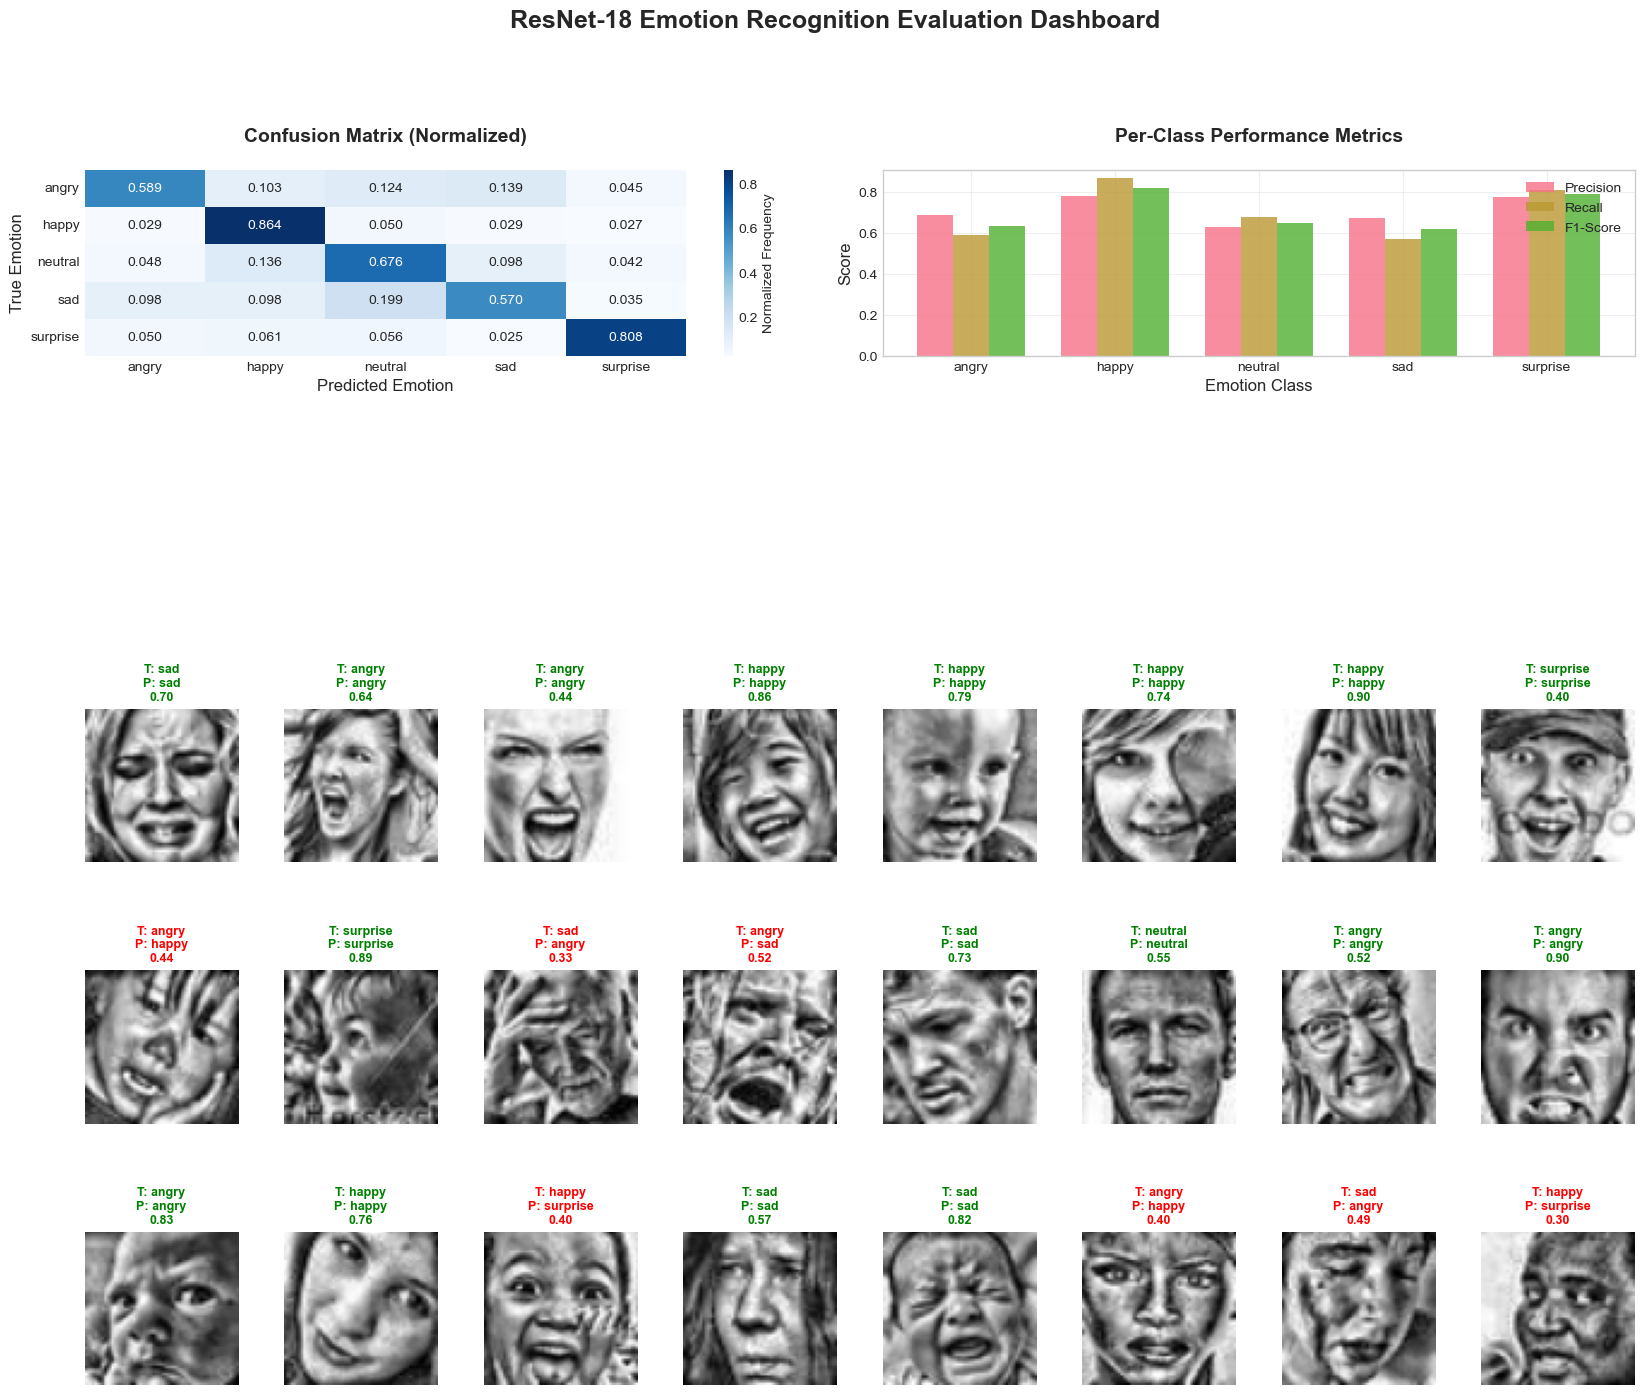

In [46]:
def create_evaluation_dashboard():
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(5, 8, hspace=0.4, wspace=0.3)
    
    # Color scheme
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # 1. Confusion Matrix
    ax1 = fig.add_subplot(gs[0, :4])
    cm = confusion_matrix(true_labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=CONFIG['emotions'], yticklabels=CONFIG['emotions'],
                ax=ax1, cbar_kws={'label': 'Normalized Frequency'})
    ax1.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Predicted Emotion', fontsize=12)
    ax1.set_ylabel('True Emotion', fontsize=12)
    
    # 2. Per-class Performance
    ax2 = fig.add_subplot(gs[0, 4:])
    class_report = classification_report(true_labels, predictions, target_names=CONFIG['emotions'], output_dict=True)
    
    metrics = ['precision', 'recall', 'f1-score']
    x = np.arange(len(CONFIG['emotions']))
    width = 0.25
    
    for i, metric in enumerate(metrics):
        values = [class_report[emotion][metric] for emotion in CONFIG['emotions']]
        ax2.bar(x + i*width, values, width, label=metric.title(), alpha=0.8)
    
    ax2.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Emotion Class', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(CONFIG['emotions'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Sample Predictions Grid
    rows, cols = 3, 8
    for i in range(min(len(sample_images), rows * cols)):
        row = i // cols
        col = i % cols
        
        ax = fig.add_subplot(gs[row + 2, col])
        ax.imshow(sample_images[i], cmap='gray')
        ax.axis('off')
        
        pred = sample_predictions[i]
        is_correct = pred['true_label'] == pred['predicted_label']
        
        title_color = 'green' if is_correct else 'red'
        title = f"T: {pred['true_emotion']}\nP: {pred['predicted_emotion']}\n{pred['confidence']:.2f}"
        
        ax.set_title(title, fontsize=9, color=title_color, fontweight='bold')
    
    plt.suptitle('ResNet-18 Emotion Recognition Evaluation Dashboard', 
                fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()

create_evaluation_dashboard()

## 8. Confidence Analysis

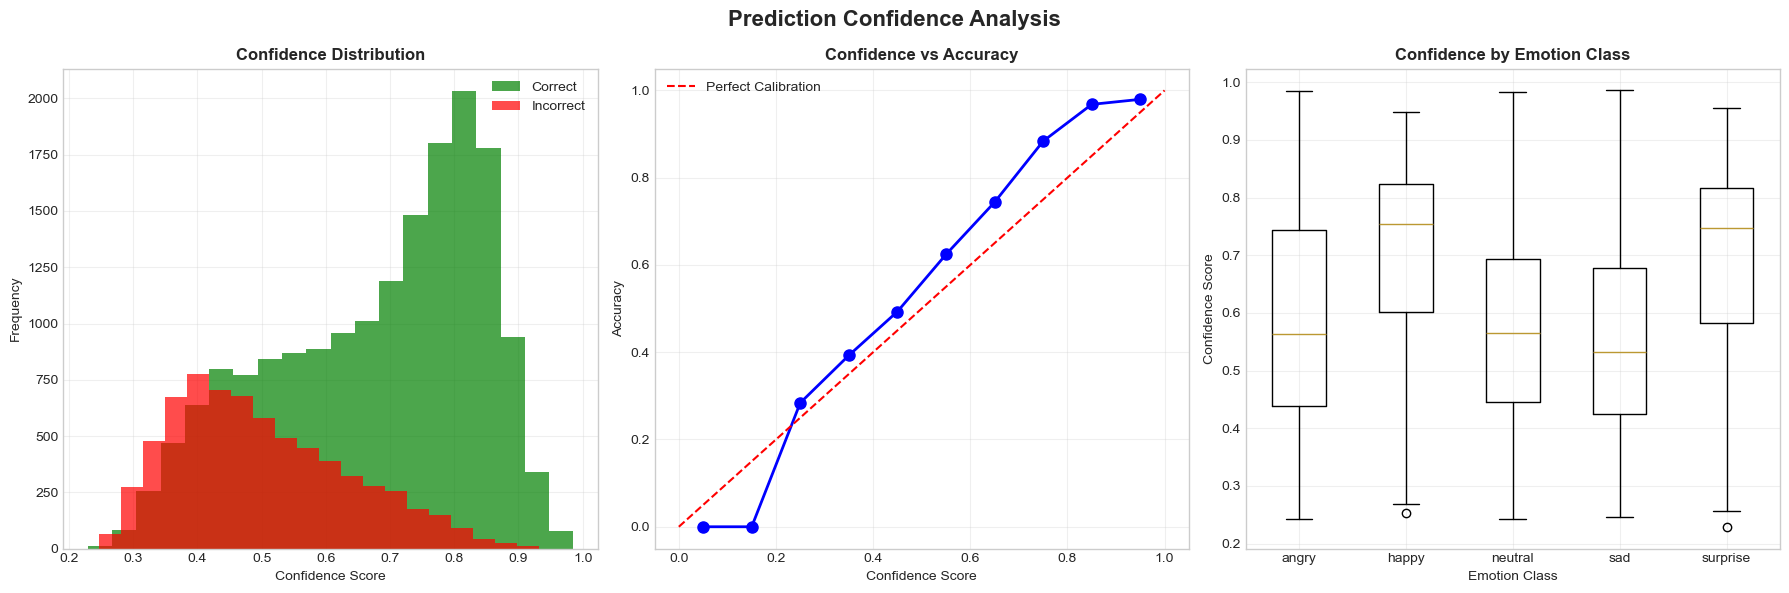

In [48]:
def analyze_prediction_confidence():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Prediction Confidence Analysis', fontsize=16, fontweight='bold')
    
    # 1. Confidence Distribution
    ax1 = axes[0]
    confidences = np.max(probabilities, axis=1)
    correct_mask = predictions == true_labels
    
    ax1.hist(confidences[correct_mask], bins=20, alpha=0.7, label='Correct', color='green')
    ax1.hist(confidences[~correct_mask], bins=20, alpha=0.7, label='Incorrect', color='red')
    ax1.set_title('Confidence Distribution', fontweight='bold')
    ax1.set_xlabel('Confidence Score')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Confidence vs Accuracy
    ax2 = axes[1]
    confidence_bins = np.linspace(0, 1, 11)
    bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
    bin_accuracies = []
    
    for i in range(len(confidence_bins) - 1):
        mask = (confidences >= confidence_bins[i]) & (confidences < confidence_bins[i + 1])
        if mask.sum() > 0:
            bin_accuracy = correct_mask[mask].mean()
            bin_accuracies.append(bin_accuracy)
        else:
            bin_accuracies.append(0)
    
    ax2.plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=8)
    ax2.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
    ax2.set_title('Confidence vs Accuracy', fontweight='bold')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Per-Class Confidence
    ax3 = axes[2]
    class_confidences = []
    for i, emotion in enumerate(CONFIG['emotions']):
        mask = true_labels == i
        if mask.sum() > 0:
            class_confidences.append(confidences[mask])
        else:
            class_confidences.append([])
    
    ax3.boxplot(class_confidences, labels=CONFIG['emotions'])
    ax3.set_title('Confidence by Emotion Class', fontweight='bold')
    ax3.set_xlabel('Emotion Class')
    ax3.set_ylabel('Confidence Score')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_prediction_confidence()

## 9. Detailed Classification Report

In [ ]:
def generate_detailed_report():
    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL EVALUATION REPORT")
    print("="*70)
    
    # Overall metrics
    print(f"\nOVERALL PERFORMANCE:")
    print(f"  Total samples evaluated: {len(true_labels):,}")
    print(f"  Overall accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Weighted precision: {precision:.4f}")
    print(f"  Weighted recall: {recall:.4f}")
    print(f"  Weighted F1-score: {f1:.4f}")
    
    # Per-class detailed report
    print(f"\nPER-CLASS PERFORMANCE:")
    print("-"*70)
    class_report = classification_report(true_labels, predictions, 
                                       target_names=CONFIG['emotions'], 
                                       output_dict=True)
    
    print(f"{'Emotion':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-"*60)
    
    for emotion in CONFIG['emotions']:
        metrics = class_report[emotion]
        print(f"{emotion:<10} {metrics['precision']:<10.3f} {metrics['recall']:<10.3f} "
              f"{metrics['f1-score']:<10.3f} {int(metrics['support']):<10}")
    
    # Confidence statistics
    confidences = np.max(probabilities, axis=1)
    correct_mask = predictions == true_labels
    
    print(f"\nCONFIDENCE ANALYSIS:")
    print(f"  Average confidence: {confidences.mean():.4f}")
    print(f"  Std confidence: {confidences.std():.4f}")
    print(f"  Confidence range: [{confidences.min():.4f}, {confidences.max():.4f}]")
    print(f"  Avg confidence (correct): {confidences[correct_mask].mean():.4f}")
    print(f"  Avg confidence (incorrect): {confidences[~correct_mask].mean():.4f}")
    
    # Confusion matrix insights
    cm = confusion_matrix(true_labels, predictions)
    print(f"\nMOST COMMON MISCLASSIFICATIONS:")
    
    misclassifications = []
    for i in range(len(CONFIG['emotions'])):
        for j in range(len(CONFIG['emotions'])):
            if i != j and cm[i, j] > 0:
                misclassifications.append((cm[i, j], CONFIG['emotions'][i], CONFIG['emotions'][j]))
    
    misclassifications.sort(reverse=True)
    for count, true_emotion, pred_emotion in misclassifications[:5]:
        percentage = (count / cm[CONFIG['emotions'].index(true_emotion)].sum()) * 100
        print(f"  {true_emotion} -> {pred_emotion}: {count} cases ({percentage:.1f}%)")
    
    print("\n" + "="*70)

generate_detailed_report()


COMPREHENSIVE MODEL EVALUATION REPORT

OVERALL PERFORMANCE:
  Total samples evaluated: 24,143
  Overall accuracy: 0.7140 (71.40%)
  Weighted precision: 0.7111
  Weighted recall: 0.7140
  Weighted F1-score: 0.7102

PER-CLASS PERFORMANCE:
----------------------------------------------------------------------
Emotion    Precision  Recall     F1-Score   Support   
------------------------------------------------------------
angry      0.686      0.589      0.633      3983      
happy      0.781      0.864      0.821      7210      
neutral    0.627      0.676      0.650      4959      
sad        0.674      0.570      0.618      4826      
surprise   0.773      0.808      0.790      3165      

CONFIDENCE ANALYSIS:
  Average confidence: 0.6274
  Std confidence: 0.1745
  Confidence range: [0.2293, 0.9856]
  Avg confidence (correct): 0.6782
  Avg confidence (incorrect): 0.5003

MOST COMMON MISCLASSIFICATIONS:
  sad -> neutral: 962 cases (19.9%)
  neutral -> happy: 676 cases (13.6%)
  angry 

## 10. Model Summary

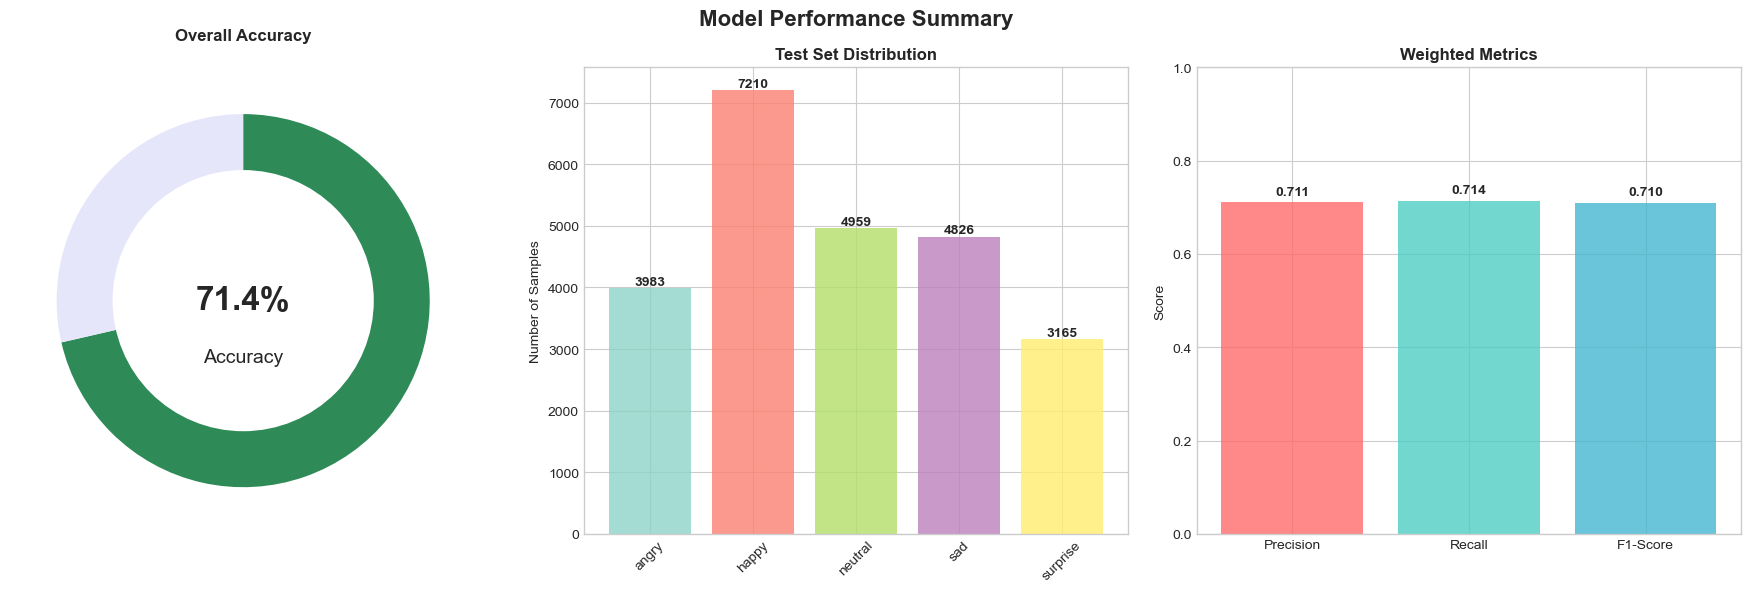


EVALUATION COMPLETED SUCCESSFULLY
Model achieved 71.40% accuracy on 24143 test samples
Best performing class: happy


In [ ]:
def create_summary_visualization():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Model Performance Summary', fontsize=16, fontweight='bold')
    
    # 1. Accuracy Gauge
    ax1 = axes[0]
    accuracy_pct = accuracy * 100
    
    # Create a pie chart to simulate gauge
    sizes = [accuracy_pct, 100 - accuracy_pct]
    colors = ['#2E8B57', '#E6E6FA']
    
    wedges, texts = ax1.pie(sizes, colors=colors, startangle=90, counterclock=False)
    
    # Add center circle to make it look like a gauge
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    ax1.add_artist(centre_circle)
    
    ax1.text(0, 0, f'{accuracy_pct:.1f}%', ha='center', va='center', 
             fontsize=24, fontweight='bold')
    ax1.text(0, -0.3, 'Accuracy', ha='center', va='center', fontsize=14)
    ax1.set_title('Overall Accuracy', fontweight='bold', pad=20)
    
    # 2. Class Distribution
    ax2 = axes[1]
    unique, counts = np.unique(true_labels, return_counts=True)
    colors_class = plt.cm.Set3(np.linspace(0, 1, len(CONFIG['emotions'])))
    
    bars = ax2.bar(CONFIG['emotions'], counts, color=colors_class, alpha=0.8)
    ax2.set_title('Test Set Distribution', fontweight='bold')
    ax2.set_ylabel('Number of Samples')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 3. Performance Comparison
    ax3 = axes[2]
    metrics = ['Precision', 'Recall', 'F1-Score']
    values = [precision, recall, f1]
    colors_metrics = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    bars = ax3.bar(metrics, values, color=colors_metrics, alpha=0.8)
    ax3.set_title('Weighted Metrics', fontweight='bold')
    ax3.set_ylabel('Score')
    ax3.set_ylim(0, 1)
    
    # Add value labels
    for bar, value in zip(bars, values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nEVALUATION COMPLETED SUCCESSFULLY")
    print(f"Model achieved {accuracy*100:.2f}% accuracy on {len(true_labels)} test samples")
    print(f"Best performing class: {CONFIG['emotions'][np.argmax([classification_report(true_labels, predictions, target_names=CONFIG['emotions'], output_dict=True)[emotion]['f1-score'] for emotion in CONFIG['emotions']])]}")

create_summary_visualization()